In [1]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = ""

# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity > /dev/null 2>&1


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please insert your Comet API Key"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 89.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.1/606.1 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 3.7 MB/s eta 0:00:00


# Dataset

In [4]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [5]:
# convert the ABC notation to audio file and Listen to it
# mdl.lab1.play_song(example_song)

One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [6]:
# join our list og song strings into a single string containing all songs
songs_joined= "\n\n".join(songs)

# find all unique characters in the joined string
vocab= sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


# Process the dataset for the learning task

We're trying to train an RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information.

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task.

We will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

# Vectorize the text

We'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [7]:
# define numerical representation of text

# create a mapping from character to unique index
# for example: to get the index of character "d"
# we can evaluate `char2idx["d"]`.
char2idx= {u: i for i, u in enumerate(vocab)}

# create a mapping from indices to characters.
# this is the inverse of char2idx and allows us 
# to convert back from unique iindex to character
# in our vocabulary
idx2char= np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to len(unique). Let's take a peek at this numerical representation of our dataset:

In [8]:
print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [9]:
# vectorize the songs string

# Limit NumPy to 2 threads to prevent high CPU usage on Kaggle
os.environ["OMP_NUM_THREADS"] = "2"

def vectorize_string(string):
    """Efficiently vectorizes a string using np.fromiter to reduce CPU & memory usage."""
    return np.fromiter((char2idx[char] for char in string), dtype=np.int32)

vectorized_songs = vectorize_string(songs_joined)

We can also look at how the first part of the text is mapped to an integer representation:

In [10]:
print('{} --- characters mapped to int ---> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' --- characters mapped to int ---> [49 22 13  0 45 22 26 67 60 79]


# Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain seq_length characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of seq_length+1. Suppose seq_length is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [11]:
# Batch definition to create training examples

def get_batch(vectorized_songs, seq_length, batch_size):
    # length of the vectorized songs string
    n= vectorized_songs.shape[0]-1
    # randomly choose thee starting indices for the examples in the training batch
    idx= np.random.choice(n- seq_length, batch_size)
    
    # construct a list of input sequences for the training batch
    input_batch= np.array([vectorized_songs[i:i+ seq_length] for i in idx])
    
    # construct a list of output sequences for the training batch
    output_batch= np.array([vectorized_songs[i+1: i+ seq_length+1] for i in idx])
    
    # convert the input and output batches to tensors
    x_batch= torch.tensor(input_batch, dtype= torch.long)
    y_batch= torch.tensor(output_batch, dtype= torch.long)

    return x_batch, y_batch

# perform some simple tests to make sure youur batch functon is working properly
test_args= (vectorized_songs, 10, 2)
x_batch, y_batch= get_batch(*test_args)
assert x_batch.shape== (2, 10), "x_batch is incorrect"
assert y_batch.shape== (2, 10), "y_batch is incorrect"
print("Batch function works correctly")

Batch function works correctly


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [12]:
x_batch, y_batch= get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(x_batch[0], y_batch[0])):
    print("Step {:3d}", format(i))
    print(" input: {} ({:s})".format(input_idx, repr(idx2char[input_idx.item()])))
    print(" expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx.item()])))

Step {:3d} 0
 input: 82 ('|')
 expected output: 32 ('G')
Step {:3d} 1
 input: 32 ('G')
 expected output: 30 ('E')
Step {:3d} 2
 input: 30 ('E')
 expected output: 1 (' ')
Step {:3d} 3
 input: 1 (' ')
 expected output: 30 ('E')
Step {:3d} 4
 input: 30 ('E')
 expected output: 11 ('/')


# The Recurrent Neural Network (RNN) Model

We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected linear *nn.Linear* layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

* nn.Embedding: This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with embedding_dim dimensions.
* nn.LSTM: Our LSTM network, with size hidden_size.
* nn.Linear: The output layer, with vocab_size outputs.


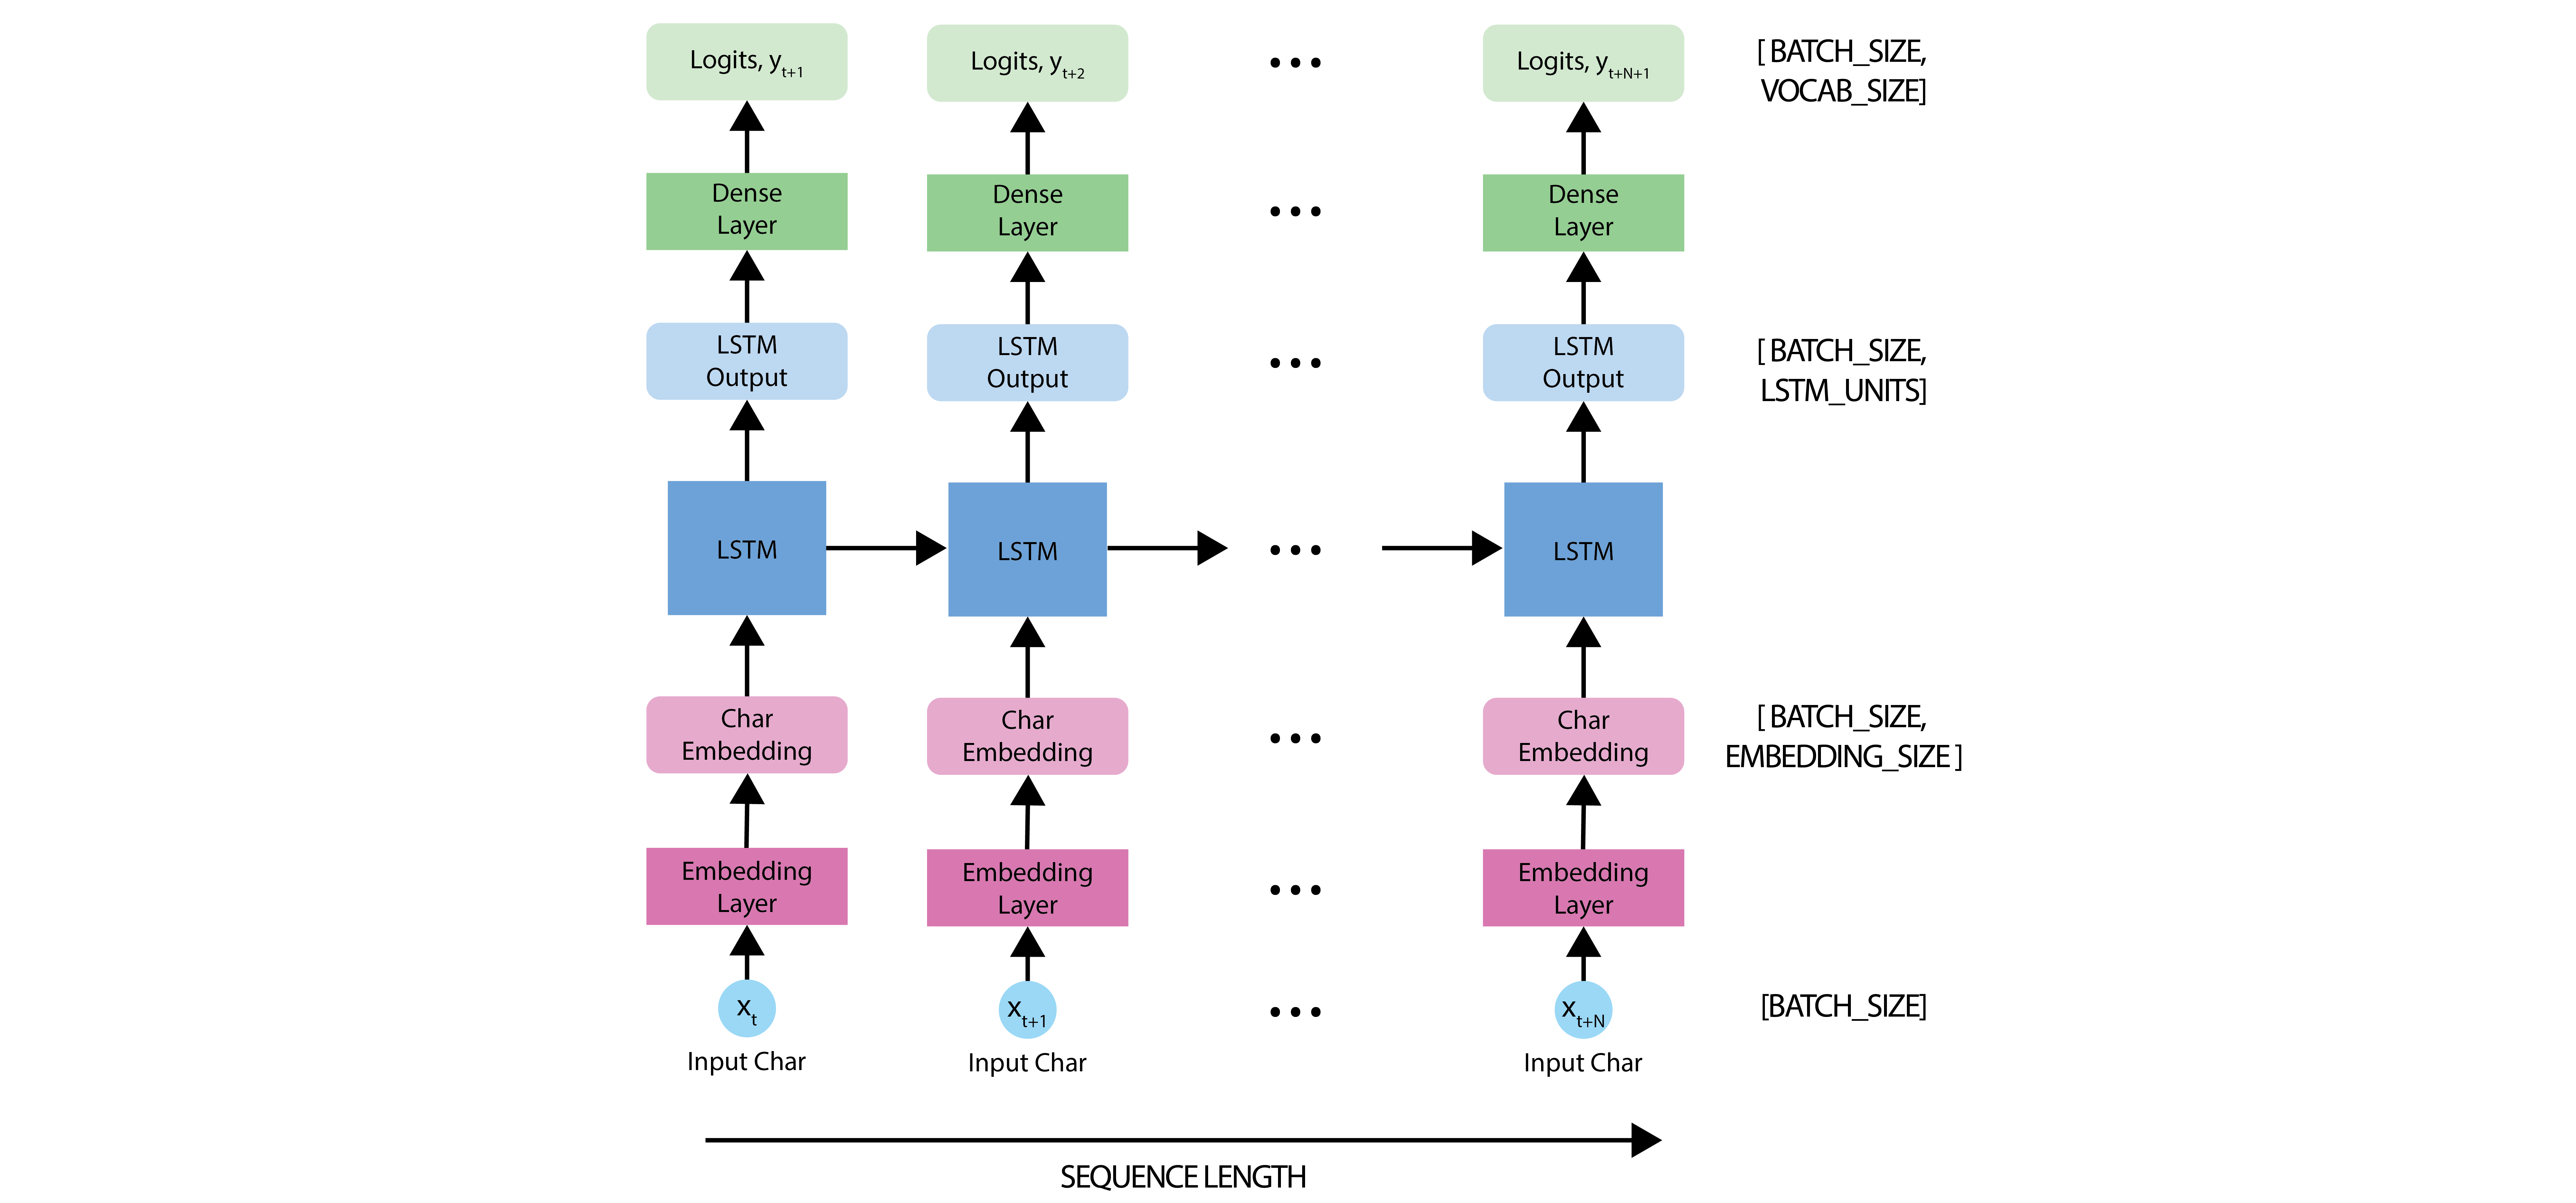

In [13]:
# Defining the RNN model

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(LSTMModel, self).__init__()
        self.hidden_size= hidden_size

        # defining each of the network layers
        # layer 1: Embedding layer to transform indices into dense vectors
        # of a fixed embedding size
        self.embedding= nn.Embedding(vocab_size, embedding_dim)

        # layer 2: LSTM (Recurrent layer)
        self.lstm= nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)

        # layer 3: Fully connected (Linear) layer
        self.fc= nn.Linear(hidden_size, vocab_size)

    def init_hidden(self, batch_size, device):
        # intialize hidden state and cell state with zeros
        return (torch.zeros(1, batch_size, self.hidden_size).to(device), torch.zeros(1, batch_size, self.hidden_size).to(device))

    def forward(self, x, state=None, return_state=False):
        x= self.embedding(x)

        if state is None:
            state= self.init_hidden(x.size(0), x.device)
        out, state= self.lstm(x, state)

        out= self.fc(out)
        return out if not return_state else (out, state)

In [14]:
# instantiate the model! Build a simple model with default hyperparameters.
# You will get chance to change these later
vocab_size= len(vocab)
embedding_dim= 256
hidden_size= 1024
batch_size= 8

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

model= LSTMModel(vocab_size, embedding_dim, hidden_size).to(device)

# print out a summary of the model
print(model)

LSTMModel(
  (embedding): Embedding(83, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=83, bias=True)
)


# Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.

We can quickly check the layers in the model, the shape of the output of each of the layers, the batch size, and the dimensionality of the output. Note that the model can be run on inputs of any length.

In [15]:
# test the model with some sample data
x, y= get_batch(vectorized_songs, seq_length=100, batch_size=32)
x= x.to(device)
y= y.to(device)

pred= model(x)
print("Input shape:    ", x.shape, "# (batch_size, sequence_length)")
print("Prediction shape:    ", pred.shape, "# (batch_size, sequence_length, vocab_size)")


Input shape:     torch.Size([32, 100]) # (batch_size, sequence_length)
Prediction shape:     torch.Size([32, 100, 83]) # (batch_size, sequence_length, vocab_size)


# Predictions from the untrained model